In [1]:
import numpy as np
import pesfit as pf
from silx.io.dictdump import dicttoh5, h5todict
import matplotlib.pyplot as plt
import lmfit.models as lmm
from tqdm import notebook as nb
from numba import njit, prange
# import ray

In [2]:
bpatch = np.zeros((2, 30, 30))
spatch = np.zeros((2, 30, 30))
gpatch = np.zeros((2, 30, 30))

# Initialize the model
mdl = pf.fitter.model_generator(peaks={'Voigt':2}, background='None')
pars = mdl.make_params()

vardict = [{'lp1_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                  'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                  'gamma':dict(value=0.02, min=0, max=2, vary=True)}},
           
           {'lp2_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                   'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                   'gamma':dict(value=0.02, min=0, max=2, vary=True)}}]

pf.fitter.varsetter(pars, vardict, ret=False)

In [47]:
# pars

In [3]:
krec = h5todict(r'E:\Momentoscope\WSe2\krec_lda_kpoint.h5')['recon']
krec.shape

(14, 30, 30)

## Fitting of a patch of photoemission spectra (patch fitting)

In [4]:
fdata = h5todict(r'...\WSe2\kpoint\kpoint_symmetrized.h5')
Es = fdata['E'][20:100]
eofs = 0.015 # Energy offset
sfts = np.arange(-0.08, 0.09, 0.01) # Choices of random shifts

### Serial patch fitting

In [ ]:
for r in range(30):
#     print(r)
    for c in range(30):

        row_id, col_id = r, c

        # Update the band position estimates (corresponding to the centers of the lineshape components)
        centerdict = [{'lp1_':{'center':dict(value=krec[0,row_id,col_id]+eofs, vary=True)}},
                      {'lp2_':{'center':dict(value=krec[1,row_id,col_id]+eofs, vary=True)}}]

        pf.fitter.varsetter(pars, centerdict, ret=False)
        y = fdata['V'][row_id, col_id, 20:100]
        fit_result = mdl.fit(y/y.max(), pars, x=Es)

        # Add random shift to the initialization to produce better fits
        out = pf.fitter.random_varshift(fit_result, model=mdl, params=pars, yvals=y, xvals=Es, shifts=sfts)
        comps = out.eval_components(x=Es)

        bpatch[0,r,c] = out.params['lp1_center'].value
        bpatch[1,r,c] = out.params['lp2_center'].value

        spatch[0,r,c] = out.params['lp1_sigma'].value
        spatch[1,r,c] = out.params['lp2_sigma'].value

        gpatch[0,r,c] = out.params['lp1_gamma'].value
        gpatch[1,r,c] = out.params['lp2_gamma'].value

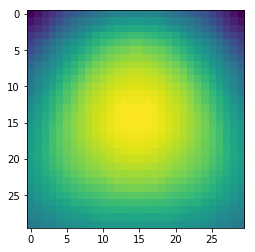

In [53]:
plt.imshow(bpatch[1,...])

### Parallel patch fitting

In [ ]:
vardict = [{'lp1_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                  'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                  'gamma':dict(value=0.02, min=0, max=2, vary=True)}},
           
           {'lp2_':{'amplitude':dict(value=0.2, min=0, max=2, vary=True),
                   'sigma':dict(value=0.1, min=0.05, max=2, vary=False),
                   'gamma':dict(value=0.02, min=0, max=2, vary=True)}}]

### Computational scaling wrt the number of components